# BERT Model 학습하기

기본적인 코드의 테스트를 위해서 노트북에서 직접 돌리는 작업을 수행해 봅니다. 다음 노트북에서 cluster 내의 training job을 시작합니다.

In [1]:
import sys

In [2]:
!{sys.executable} -m pip install -q pip --upgrade
!{sys.executable} -m pip install -q wrapt==1.11.2
!{sys.executable} -m pip install -q tensorflow==2.1.0
!{sys.executable} -m pip install -q transformers==2.8.0

In [3]:
import time
import random
import pandas as pd
from glob import glob
import argparse
import json
import subprocess
import sys
import os
import tensorflow as tf
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import TextClassificationPipeline
from transformers.configuration_distilbert import DistilBertConfig

In [4]:
MAX_SEQ_LENGTH=128
BATCH_SIZE=8
EPOCHS=1
STEPS_PER_EPOCH=50
VALIDATION_STEPS=50
TEST_STEPS=50
CLASSES = [1, 2, 3, 4, 5]
NUM_GPUS=0

In [5]:
def select_data_and_label_from_record(record):
    x = {
        'input_ids': record['input_ids'],
        'input_mask': record['input_mask'],
        'segment_ids': record['segment_ids']
    }
    y = record['label_ids']

    return (x, y)

In [6]:
def file_based_input_dataset_builder(channel,
                                     input_filenames,
                                     pipe_mode,
                                     is_training,
                                     drop_remainder):

    # For training, we want a lot of parallel reading and shuffling.
    # For eval, we want no shuffling and parallel reading doesn't matter.

    if pipe_mode:
        print('***** Using pipe_mode with channel {}'.format(channel))
        from sagemaker_tensorflow import PipeModeDataset
        dataset = PipeModeDataset(channel=channel,
                                  record_format='TFRecord')
    else:
        print('***** Using input_filenames {}'.format(input_filenames))
        dataset = tf.data.TFRecordDataset(input_filenames)

    dataset = dataset.repeat(EPOCHS * STEPS_PER_EPOCH)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    name_to_features = {
      "input_ids": tf.io.FixedLenFeature([MAX_SEQ_LENGTH], tf.int64),
      "input_mask": tf.io.FixedLenFeature([MAX_SEQ_LENGTH], tf.int64),
      "segment_ids": tf.io.FixedLenFeature([MAX_SEQ_LENGTH], tf.int64),
      "label_ids": tf.io.FixedLenFeature([], tf.int64),
    }

    def _decode_record(record, name_to_features):
        """Decodes a record to a TensorFlow example."""
        return tf.io.parse_single_example(record, name_to_features)
        
    dataset = dataset.apply(
        tf.data.experimental.map_and_batch(
          lambda record: _decode_record(record, name_to_features),
          batch_size=BATCH_SIZE,
          drop_remainder=drop_remainder,
          num_parallel_calls=tf.data.experimental.AUTOTUNE))

    dataset.cache()

    if is_training:
        dataset = dataset.shuffle(seed=42,
                                  buffer_size=10,
                                  reshuffle_each_iteration=True)

    return dataset

In [7]:
%store -r

In [8]:
train_data_filenames = glob('{}/*.tfrecord'.format(train_data))
print('train_data_filenames {}'.format(train_data_filenames))
train_dataset = file_based_input_dataset_builder(
    channel='train',
    input_filenames=train_data_filenames,
    pipe_mode=False,
    is_training=True,
    drop_remainder=False).map(select_data_and_label_from_record)

train_data_filenames ['./data-tfrecord/bert-train/part-algo-1-amazon_reviews_us_Musical_Instruments_v1_00.tfrecord', './data-tfrecord/bert-train/part-algo-2-amazon_reviews_us_Digital_Video_Games_v1_00.tfrecord', './data-tfrecord/bert-train/part-algo-1-amazon_reviews_us_Digital_Software_v1_00.tfrecord']
***** Using input_filenames ['./data-tfrecord/bert-train/part-algo-1-amazon_reviews_us_Musical_Instruments_v1_00.tfrecord', './data-tfrecord/bert-train/part-algo-2-amazon_reviews_us_Digital_Video_Games_v1_00.tfrecord', './data-tfrecord/bert-train/part-algo-1-amazon_reviews_us_Digital_Software_v1_00.tfrecord']
Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


In [9]:
validation_data_filenames = glob('{}/*.tfrecord'.format(validation_data))

print('validation_data_filenames {}'.format(validation_data_filenames))
validation_dataset = file_based_input_dataset_builder(
    channel='validation',
    input_filenames=validation_data_filenames,
    pipe_mode=False,
    is_training=False,
    drop_remainder=False).map(select_data_and_label_from_record)

validation_data_filenames ['./data-tfrecord/bert-validation/part-algo-1-amazon_reviews_us_Musical_Instruments_v1_00.tfrecord', './data-tfrecord/bert-validation/part-algo-2-amazon_reviews_us_Digital_Video_Games_v1_00.tfrecord', './data-tfrecord/bert-validation/part-algo-1-amazon_reviews_us_Digital_Software_v1_00.tfrecord']
***** Using input_filenames ['./data-tfrecord/bert-validation/part-algo-1-amazon_reviews_us_Musical_Instruments_v1_00.tfrecord', './data-tfrecord/bert-validation/part-algo-2-amazon_reviews_us_Digital_Video_Games_v1_00.tfrecord', './data-tfrecord/bert-validation/part-algo-1-amazon_reviews_us_Digital_Software_v1_00.tfrecord']


In [10]:
test_data_filenames = glob('{}/*.tfrecord'.format(test_data))

print(test_data_filenames)

test_dataset = file_based_input_dataset_builder(
    channel='test',
    input_filenames=test_data_filenames,
    pipe_mode=False,
    is_training=False,
    drop_remainder=False).map(select_data_and_label_from_record)

['./data-tfrecord/bert-test/part-algo-1-amazon_reviews_us_Musical_Instruments_v1_00.tfrecord', './data-tfrecord/bert-test/part-algo-2-amazon_reviews_us_Digital_Video_Games_v1_00.tfrecord', './data-tfrecord/bert-test/part-algo-1-amazon_reviews_us_Digital_Software_v1_00.tfrecord']
***** Using input_filenames ['./data-tfrecord/bert-test/part-algo-1-amazon_reviews_us_Musical_Instruments_v1_00.tfrecord', './data-tfrecord/bert-test/part-algo-2-amazon_reviews_us_Digital_Video_Games_v1_00.tfrecord', './data-tfrecord/bert-test/part-algo-1-amazon_reviews_us_Digital_Software_v1_00.tfrecord']


In [11]:
config = DistilBertConfig.from_pretrained('distilbert-base-uncased',
                                          num_labels=len(CLASSES))
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', 
                                                              config=config)

# Setup the Custom Classifier Model Here

In [12]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08)
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
model.layers[0].trainable = False
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
_________________________________________________________________
pre_classifier (Dense)       multiple                  590592    
_________________________________________________________________
classifier (Dense)           multiple                  3845      
_________________________________________________________________
dropout_19 (Dropout)         multiple                  0         
Total params: 66,957,317
Trainable params: 594,437
Non-trainable params: 66,362,880
_________________________________________________________________


In [13]:
callbacks = []

log_dir = './tensorboard/'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
callbacks.append(tensorboard_callback)

In [14]:
history = model.fit(train_dataset,
                    shuffle=True,
                    epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=validation_dataset,
                    validation_steps=VALIDATION_STEPS,
                    callbacks=callbacks)

Train for 50 steps, validate for 50 steps
50/50 [==============================] - 60s 1s/step - loss: 1.4124 - accuracy: 0.6225 - val_loss: 1.4372 - val_accuracy: 0.4700


In [15]:
print('Trained model {}'.format(model))

Trained model <transformers.modeling_tf_distilbert.TFDistilBertForSequenceClassification object at 0x7f69586beda0>


# Evaluate on Holdout Test Dataset

In [16]:
test_history = model.evaluate(test_dataset,
                              steps=TEST_STEPS,                            
                              callbacks=callbacks)
print(test_history)

50/50 [==============================] - 27s 533ms/step - loss: 1.2754 - accuracy: 0.6025
[1.2754247093200684, 0.6025]


# Save the Model

In [17]:
model_dir = './fine-tuned'

In [18]:
!mkdir -p $model_dir
model.save_pretrained(model_dir)

In [19]:
!ls -al $model_dir

total 261692
drwxrwxr-x  2 ec2-user ec2-user      4096 Sep 15 06:13 .
drwxrwxr-x 13 ec2-user ec2-user      4096 Sep 15 07:38 ..
-rw-rw-r--  1 ec2-user ec2-user      1358 Sep 15 07:38 config.json
-rw-rw-r--  1 ec2-user ec2-user 267959068 Sep 15 07:38 tf_model.h5


In [20]:
cat $model_dir/config.json

{
  "_num_labels": 5,
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "bad_words_ids": null,
  "bos_token_id": null,
  "decoder_start_token_id": null,
  "dim": 768,
  "do_sample": false,
  "dropout": 0.1,
  "early_stopping": false,
  "eos_token_id": null,
  "finetuning_task": null,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 512,
  "min_length": 0,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "no_repeat_ngram_size": 0,
  "num_beams": 1,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true

In [21]:
import json
from transformers import TFDistilBertForSequenceClassification

loaded_model = TFDistilBertForSequenceClassification.from_pretrained(model_dir,
                                                                     id2label={
                                                                       0: 1,
                                                                       1: 2,
                                                                       2: 3,
                                                                       3: 4,
                                                                       4: 5
                                                                     },
                                                                     label2id={
                                                                       1: 0,
                                                                       2: 1,
                                                                       3: 2,
                                                                       4: 3,
                                                                       5: 4
                                                                     })

In [22]:
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

if NUM_GPUS >= 1:
    inference_device = 0 # GPU 0
else:
    inference_device = -1 # CPU
print('inference_device {}'.format(inference_device))

inference_device -1


In [23]:
from transformers import TextClassificationPipeline
inference_pipeline = TextClassificationPipeline(model=loaded_model, 
                                                tokenizer=tokenizer,
                                                framework='tf',
                                                device=inference_device) # -1 is CPU, >= 0 is GPU

print("""I loved it!  I will recommend this to everyone.""", inference_pipeline("""I loved it!  I will recommend this to everyone."""))
print("""Really bad.  I hope they don't make this anymore.""", inference_pipeline("""Really bad.  I hope they don't make this anymore."""))

I loved it!  I will recommend this to everyone. [{'label': 5, 'score': 0.35214776}]
Really bad.  I hope they don't make this anymore. [{'label': 5, 'score': 0.34699106}]


# Test Model

In [24]:
import csv

df_sample_reviews = pd.read_csv('./data/amazon_reviews_us_Digital_Software_v1_00.tsv.gz', 
                                delimiter='\t', 
                                quoting=csv.QUOTE_NONE,
                                compression='gzip')[['review_body', 'star_rating']].sample(n=100)
df_sample_reviews.shape

(100, 2)

In [25]:
df_sample_reviews.head()

,review_body,star_rating
94698,"Before I send my financial data up into a \\""c...",1
53409,I was skeptical this would help make my laptop...,5
34133,New to business. The expense category is all ...,3
56384,Being online feels a little bit safer with Nor...,4
54319,"When i built my pc a few months back, I was re...",5


In [26]:
import pandas as pd

def predict(review_body):
    prediction_map = inference_pipeline(review_body)
    return prediction_map[0]['label']
    
y_pred = df_sample_reviews['review_body'].map(predict)

y_pred

94698     5
53409     5
34133     5
56384     5
54319     5
         ..
101012    5
43837     5
51454     5
39611     5
28543     5
Name: review_body, Length: 100, dtype: int64

In [27]:
y_true = df_sample_reviews['star_rating']

y_true

94698     1
53409     5
34133     3
56384     4
54319     5
         ..
101012    1
43837     1
51454     5
39611     5
28543     5
Name: star_rating, Length: 100, dtype: int64

# Classification Report

In [28]:
from sklearn.metrics import classification_report

print(classification_report(y_true=y_true, y_pred=y_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        23
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        11
           4       0.00      0.00      0.00        12
           5       0.44      1.00      0.61        44

    accuracy                           0.44       100
   macro avg       0.09      0.20      0.12       100
weighted avg       0.19      0.44      0.27       100



/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Accuracy

In [29]:
from sklearn.metrics import accuracy_score

print('Accuracy: ', accuracy_score(y_pred=y_pred, y_true=y_true))

Accuracy:  0.44


# Confusion Matrix

In [30]:
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

def plot_conf_mat(cm, classes, title, cmap = plt.cm.Greens):
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="black" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

[[ 0  0  0  0 23]
 [ 0  0  0  0 10]
 [ 0  0  0  0 11]
 [ 0  0  0  0 12]
 [ 0  0  0  0 44]]


<Figure size 432x288 with 0 Axes>

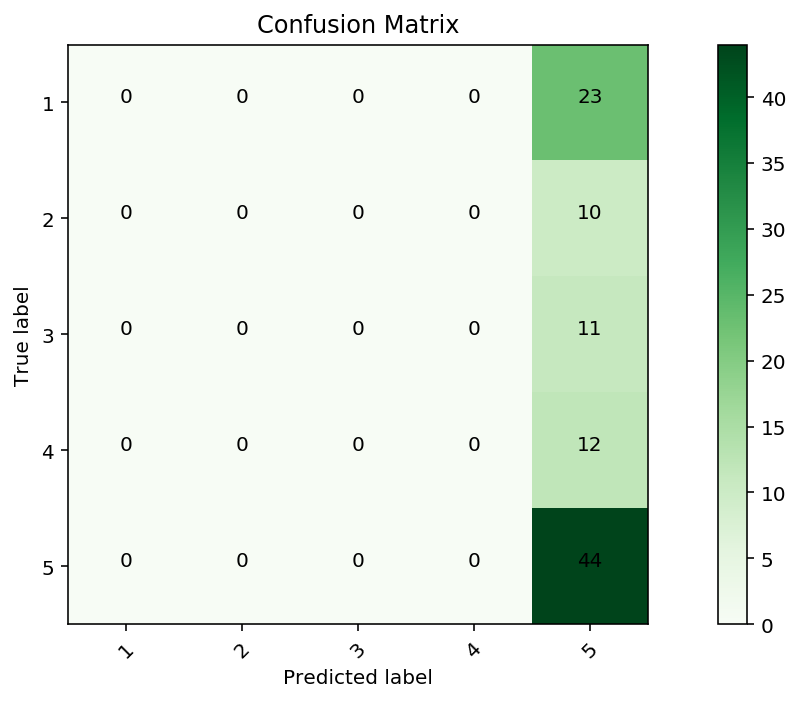

In [31]:
import itertools
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

cm = confusion_matrix(y_true=y_true, y_pred=y_pred)

plt.figure()
fig, ax = plt.subplots(figsize=(10,5))
plot_conf_mat(cm, 
              classes=['1', '2', '3', '4', '5'], 
              title='Confusion Matrix')
plt.show()